In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [3]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [5]:
lsbg_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/candy/candy_cutout_cat_candy.fits')
print('# of LSBGs:', len(lsbg_cat))

# of LSBGs: 781


In [6]:
lsbg = lsbg_cat[lsbg_cat['viz-id']==712][0] # 12 # 69

In [7]:
lsbg['viz-id']

712

In [8]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17.5)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [11]:
f"{lsbg['prefix']}_i.fits"

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/candy/candy_712_i.fits'

In [12]:
import sys
sys.path.append('/home/jiaxuanl/Research/Packages/pymfit/')
import pymfit

In [13]:
img_fn = '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/candy/candy_712_i.fits'
mask_fn = './test_mask.fits'

In [22]:
mask_kws = dict(out_fn=mask_fn, thresh=1.2, kern_sig=1.0, backsize=10, 
                obj_rmin=5, grow_sig=3.0, use_hsc_mask=False)
final_mask = pymfit.make_mask(img_fn, **mask_kws)

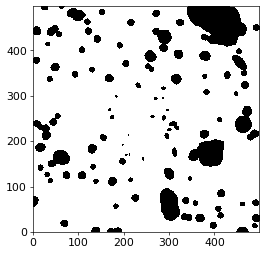

In [23]:
plt.imshow(final_mask, origin='lower', cmap='gray_r');

In [26]:
X0, Y0 = pymfit.get_img_center(img_fn)

In [28]:
model = pymfit.Model(
    funcs = 'Sersic',    # Function names
    params = None,       # Initial params that are different from default
    centers = [X0, Y0],  # guess for centers
    dcent = 30           # delta center (i.e., (X0, Y0) +/- dcent)
)
fitter = pymfit.PymFitter(model)

In [29]:
fitter.run(img_fn+'[1]', var_fn=img_fn+'[3]', mask_fn=mask_fn, will_viz=True) 
fitter.viz_results();

FileNotFoundError: [Errno 2] No such file or directory: './best-fit.txt'

In [24]:
# intial params that are different from defaults.
# syntax is {parameter: [value, low, high]}
init_params = dict(PA=[20, 0, 360], n=[1.0, 0.01, 5.0]) 

# create a config dictionary
config = pymfit.sersic_config(init_params, img_shape=img_fn)

# run imfit
# note that the image file is a multi-extension cube, which explains the '[#]' additions
# also note that this config will be written to config_fn. if you already have a 
# config file written, then use config=None (default) and skip the above step. 
sersic = pymfit.run(img_fn+'[1]', config_fn='./config.txt', 
                    mask_fn=mask_fn, config=config, var_fn=img_fn+'[3]', 
                    out_fn='./best-fit.dat')

FileNotFoundError: [Errno 2] No such file or directory: './best-fit.dat'

In [25]:
mask_kws = dict(thresh=1.2, kern_sig=1.0, backsize=10, 
                obj_rmin=5, grow_sig=3.0, use_hsc_mask=False)
run_kws = dict() # can pass pymfit.run kwargs with this
init_params = dict(PA=[20, 0, 360], n=[1.0, 0.01, 5.0]) 

sersic = pymfit.tasks.sersic_fit(img_fn, init_params=init_params, mask_kws=mask_kws, 
                                 visualize=True,
                                 run_kws=run_kws)

FileNotFoundError: [Errno 2] No such file or directory: 'fit_bestfit_params.txt'

In [ ]:


mask_kws = dict(out_fn=mask_fn, thresh=1.2, kern_sig=1.0, backsize=10, 
                obj_rmin=5, grow_sig=3.0, use_hsc_mask=False)
final_mask = pymfit.make_mask(img_fn, **mask_kws)

In [9]:
# fitter = ScarletFitter(method='wavelet', tigress=True, bright=bright,
#                        starlet_thresh=0.3, min_grad=-0.2,
#                        monotonic=True, bkg=True,
#                        variance=0.015**2, 
#                        scales=[0, 1, 2, 3, 4],
#                        prefix='candy', 
#                        log_dir='./log/candy/', 
#                        figure_dir='./Figure/candy/',
#                        model_dir='./Model/candy/spergel/',
#                        index=lsbg['viz-id'], 
#                        show_figure=True)
# fitter.load_data(data, lsbg_coord)

fitter = ScarletFitter(method='spergel', tigress=True, bright=bright,
                       starlet_thresh=0.5, min_grad=-0.1, bkg=True,
#                        monotonic=True, 
#                        variance=0.015**2, 
#                        scales=[0, 1, 2, 3, 4],
                       prefix='candy', 
                       log_dir='./log/candy/', 
                       figure_dir='./Figure/candy/',
                       model_dir='./Model/candy/spergel/',
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

In [ ]:
fitter.fit()

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    4 stars from Gaia are masked!
    Detected 86 objects
    4 stars from Gaia are masked!
    Detected 62 objects
    Detected 27 objects
  - Added Spergel profile with bbox = (4, 150, 150)
    Added constant sky background
    Total number of sources: 3
  - Optimizing scarlet model...


#### Step-by-step

In [132]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    7 stars from Gaia are masked!


In [133]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 115 objects


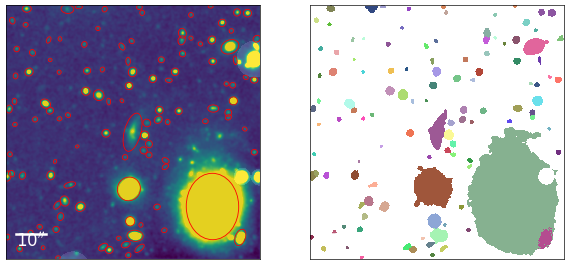

In [134]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
fitter._first_detection(first_dblend_cont, conv_radius=2, lvl=4)

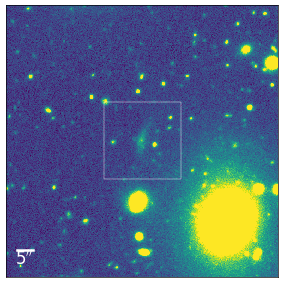

In [135]:
fitter._estimate_box(fitter.cen_obj)

In [136]:
fitter._mask_stars_outside_box()

    7 stars from Gaia are masked!


    Detected 115 objects


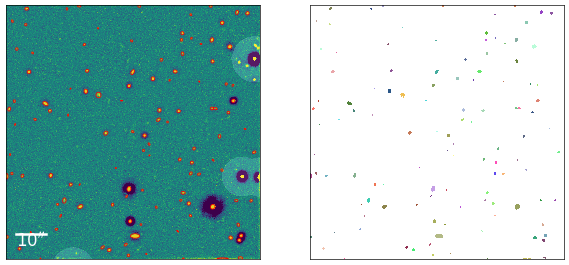

In [137]:
fitter._cpct_obj_detection()

In [138]:
from kuaizi.display import draw_circles

    Detected 57 objects


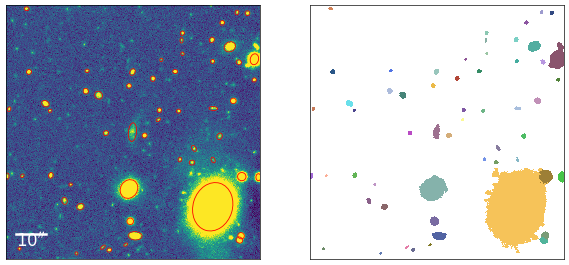

In [139]:
fitter._big_obj_detection()

In [140]:
fitter._merge_catalogs()

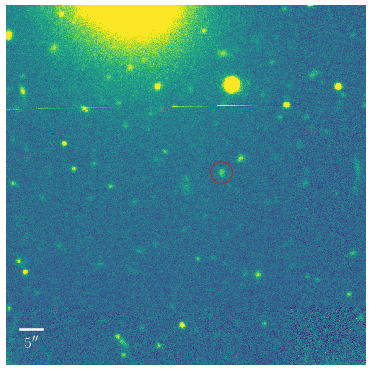

In [31]:
draw_circles(fitter.data.images[0], fitter.obj_cat_big)

In [141]:
fitter._construct_obs_frames()

In [142]:
# src = fitter.cen_obj

In [53]:
fitter._add_central_source(min_grad=fitter.min_grad, thresh=0.1)
fitter._add_other_sources(min_grad=0.1, thresh=0.1)

  - Added Spergel profile with bbox = (4, 150, 150)
    Added constant sky background
    Total number of sources: 6


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

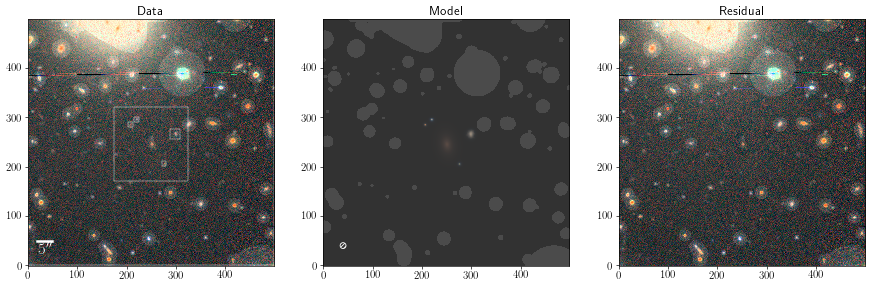

In [35]:
kz.display.display_scarlet_model(
    fitter.blend,
#     show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.9,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 186 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 266 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 346 iterations! Try higher accuracy!
  - After 346 iterations, logL = 210382.09
    Elapsed time for fitting: 110.68 s


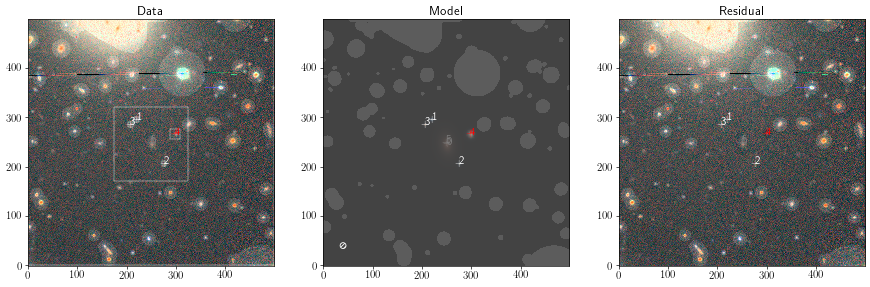

In [36]:
fitter._optimize()

In [48]:
fitter.blend.sources[0].get_model().sum(axis=(1, 2))

Parameter([6.46851968e-17, 6.46851968e-17, 6.46851968e-17, 6.46851968e-17])

In [120]:
try:
    fitter._find_sed_ind()
    fitter._gen_final_mask()
    fitter._display_results()
except:
    pass

  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/candy/spergel/candy-413-trained-model-spergel.df


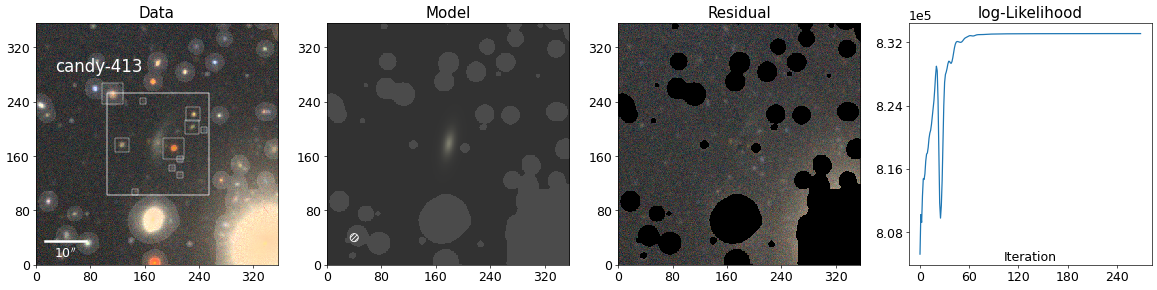

In [121]:
fitter._display_results()

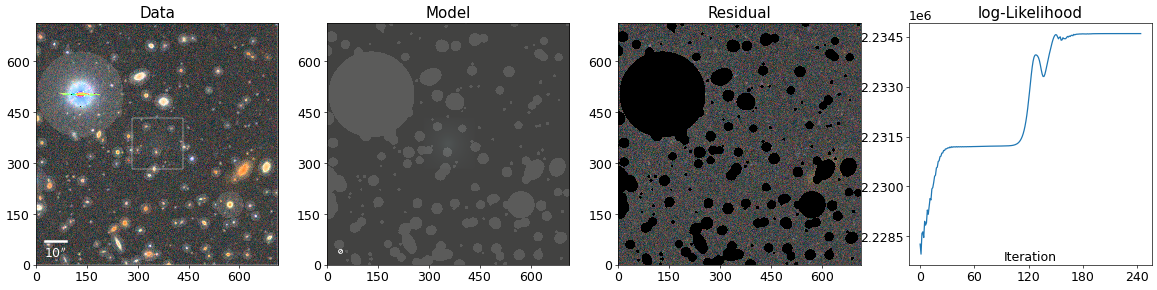

In [239]:
fig = kz.display.display_scarlet_results_tigress(
        fitter._blend,
        fitter.final_mask,
#         show_ind=fitter.sed_ind,
#         zoomin_size=50,
        minimum=-0.2,
        stretch=0.7,
        Q=1,
        channels=fitter.data.channels,
        show_loss=True,
        show_mask=False,
        show_mark=False,
        scale_bar=True)

In [240]:
from kuaizi.measure import cal_cnu
david = fitter.blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
print('mag:', -2.5 * np.log10(true_flux * sed) + 27.0)
print('Sky:', -2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27)

[[9.78091718]]
mag: [[20.95255956 20.47541381 20.3080208  20.54341934]]
Sky: [30.39239143 29.73059861 28.67050248 28.82035989]


[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

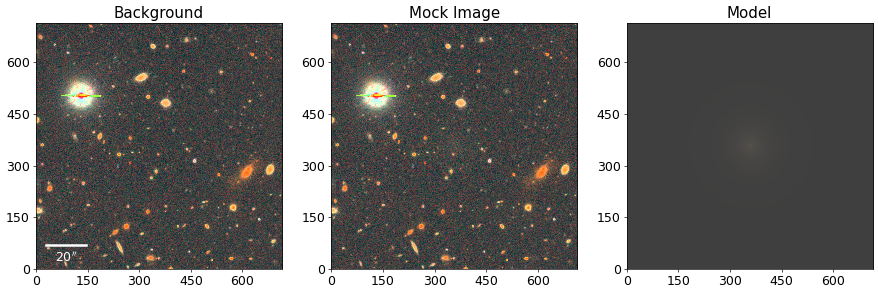

In [241]:
import pickle

with open(f'./Cutout/mock_sample/mock_{lsbg["viz-id"]}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)

In [244]:
gal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 0.9633822325633931,
    'half_light_radius': 12.097237240417355},
   'shear_params': {'q': 0.956260928877007,
    'beta': coord.Angle(-1.2817051303891247, coord.radians)},
   'sed': array([0.5723978 , 0.83970861, 1.        , 1.16199369])}],
 'imag': 19.8831568836033,
 'flux_fraction': [1.0],
 'ra': 346.1801183805011,
 'dec': 0.9159681129547782,
 'gmag': 20.4889119964195,
 'rmag': 20.072835367354816,
 'zmag': 19.720147458149533}

In [51]:
from PIL import Image

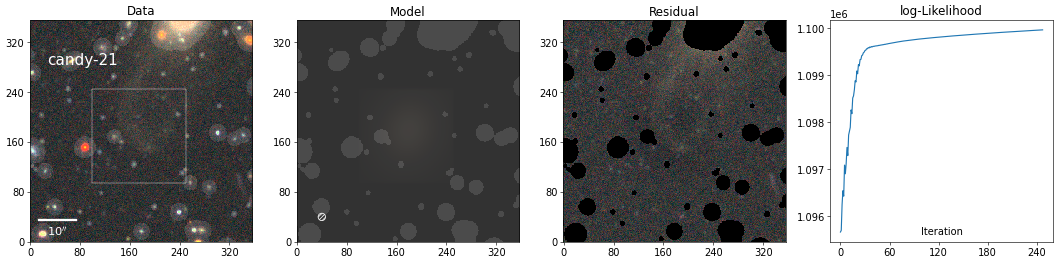

In [57]:
Image.open('./Figure/candy/spergel/candy-21-zoomin-spergel.png')

In [85]:
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

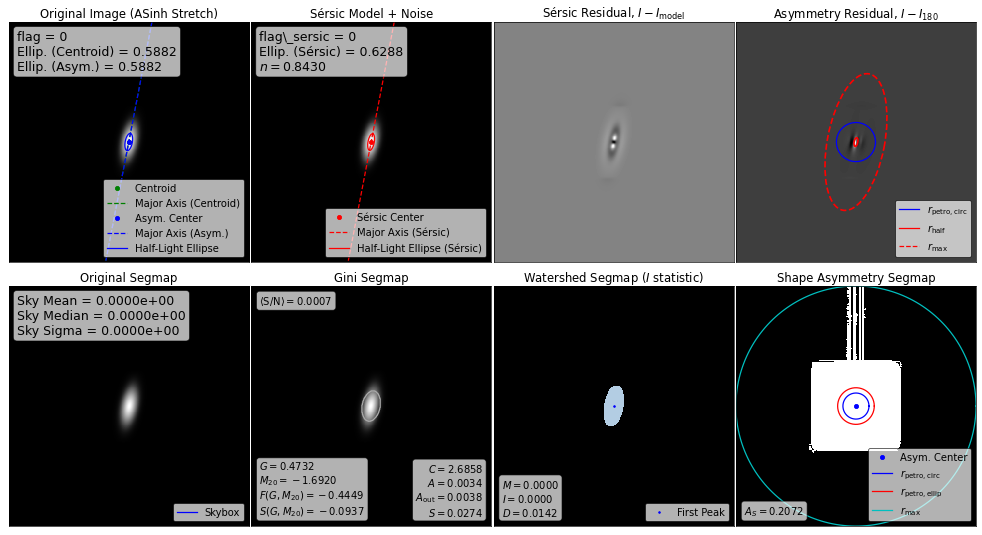

In [122]:
measurement, t = makeMeasurement(list(np.array(fitter.blend.sources)[fitter.sed_ind]),
                                 fitter.blend.observations[0],
                                 aggr_mask=fitter.final_mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 method='spergel',
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [123]:
# Sky SB
-2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27

Parameter([27.80146709, 27.02953743, 26.84623315, 26.54495943])

In [124]:
27 - 2.5 * np.log10(measurement['flux'])

array([22.5899559 , 21.86365037, 21.56390445, 21.43734834])

In [131]:
measurement['SB_eff_avg']

array([25.89437545, 25.16806992, 24.868324  , 24.74176789])

In [128]:
print(measurement['rhalf_circularized'] * 0.168)
print(measurement['sersic_rhalf'] * 0.168)
print(measurement['rhalf_spergel'] * 0.168)

1.966776036835774
2.95642699359725
1.8272331931478951


In [129]:
measurement['SB_eff_avg']

array([25.89437545, 25.16806992, 24.868324  , 24.74176789])

In [130]:
lsbg

UV,viz-id,ra,dec,iSB,e_iSB,mag_auto_i,e_imag,g-r,g-i,Reff,e_Reff,n,e_n,Ell,e_Ell,Ag,Ar,Ai,recno,flux_radius_ave_i,cutout_size,prefix,RA,DEC,radius,image_flag [5],psf_flag [5]
,,,,mag / arcsec2,mag / arcsec2,mag,mag,mag,mag,arcsec,arcsec,,,,,mag,mag,mag,,arcsec,,,,,arcmin,,
bytes1,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,bytes59,float64,float64,float64,bool,bool
,413,131.82191,1.9024,23.49,0.4,21.08,0.25,0.76,1.0,4.36,0.81,1.33,0.32,0.63,0.03,0.104,0.074,0.052,413,4.36,0.7,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/candy/candy_413,131.82191,1.9024,0.7,True .. True,True .. True


In [104]:
print(measurement['rhalf_circularized'] * 0.168)
print(gal.model.info['comp'][0]['model_params']['half_light_radius'])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

4.914961939897793
4.556496604388463


5.068036433903733

In [105]:
measurement['SB_eff_avg'], measurement['mag']

(array([25.790022, 25.45826 , 25.405367, 25.216639], dtype=float32),
 array([20.323706, 19.991943, 19.93905 , 19.75032 ], dtype=float32))

In [106]:
-2.5 * np.log10(measurement['flux_circ']) + 27

array([20.344858, 20.013096, 19.960203, 19.771473], dtype=float32)

In [107]:
gal.model.info['gmag'], gal.model.info['rmag'], gal.model.info['imag']

(20.420431085096865, 20.089120531929915, 19.987150741690147)

In [108]:
measurement['ellipticity_asymmetry'], 1 - gal.model.info['comp'][0]['shear_params']['q']

(0.12251074353348768, 0.1277100516230144)